In [133]:
from __future__ import absolute_import, division, print_function

# system imports

import sys 
import os
import requests
import argparse
import warnings

#warnings.filterwarnings("ignore")

#if not sys.warnoptions:
    
#    warnings.simplefilter("ignore")

# torch and timm imports

import torch
from torch.optim import *

# If diff timm version is installed: os.system("pip3 install timm==0.4.5")

import timm
assert timm.__version__ == "0.4.5"

# local imports and utils

import models_mae
from universal_mae_helpers import load_model, get_cuda_devices, get_out_dir, initialize_visual_cue, get_optimizer
from universal_mae_trainer import train
from util.datasets import * 
import config

# plotting and other general imports

from matplotlib import pyplot as plt 
import numpy as np
import pickle 
from distutils.util import strtobool
from PIL import Image
from colorama import Fore, Style

# logging tools

from comet_ml import Experiment
from util.datasets import make_dataset

In [135]:
model, _               = load_model(ViT_mode='large', prompt=True)

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 15.78 GiB total capacity; 3.42 GiB already allocated; 14.44 MiB free; 3.62 GiB reserved in total by PyTorch)

In [3]:
state = torch.load("models/voc/segmentation/large.pth") #"models/maze/path_finding_5x5/large.pth")

model.load_state_dict(state)

<All keys matched successfully>

In [4]:
if torch.cuda.device_count() > 1:
        
    model = torch.nn.DataParallel(model, device_ids=[0,1])

In [5]:
file                   = open("./prompts/voc/finetuned/segmentation/large.p", "rb") #open('prompts/maze/finetuned/path_finding_5x5/large.p', 'rb') 
visual_cue             = pickle.load(file)

In [36]:
# data_test = iter(make_dataset(dataset_name="oxford-pets", batch_size=16, dataset_path="data/oxford-pets", image_size=112, split="test"))
data_test = iter(make_dataset(dataset_name="voc", batch_size=16, dataset_path="data/voc/VOCdevkit/VOC2012/", image_size=112, split="test"))
#data_test              = iter(make_dataset["single_task"](dataset_name="oxford-pets", task="segmentation", batch_size=16, split="test"))
#data_train, data_val   = make_dataset["single_task"](dataset_name="oxford-pets", task="segmentation", batch_size=16, split="trainval")

Read 1449 valid examples


In [42]:
data_batch            = next(data_test) #next(iter(data_train)) #

In [9]:
visual_cue.shape

torch.Size([1, 224, 112, 3])

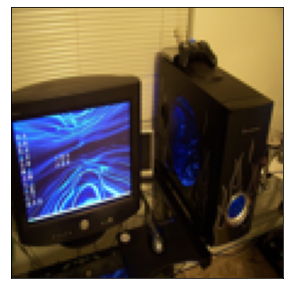

In [38]:
raw_img                = torch.einsum("chw->hwc", data_batch[0][6, :, :, :]) #data_test[50, :, :, :] 

plt.figure(figsize=(5, 5))

fig        = plt.imshow(raw_img)

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [43]:
from skimage.transform import resize
from universal_mae_helpers import *

test_img   = stitch_visual_collage(data_batch, visual_cue, 16, "hwc").detach()[4, :, :, :] #torch.cat([raw_img, visual_cue[0, :, :, :]], dim=1).detach() #
test_img   = test_img - imagenet_mean
test_img   = test_img / imagenet_std

concat_train_batch:torch.Size([16, 3, 224, 112])


MAE with pixel reconstruction:


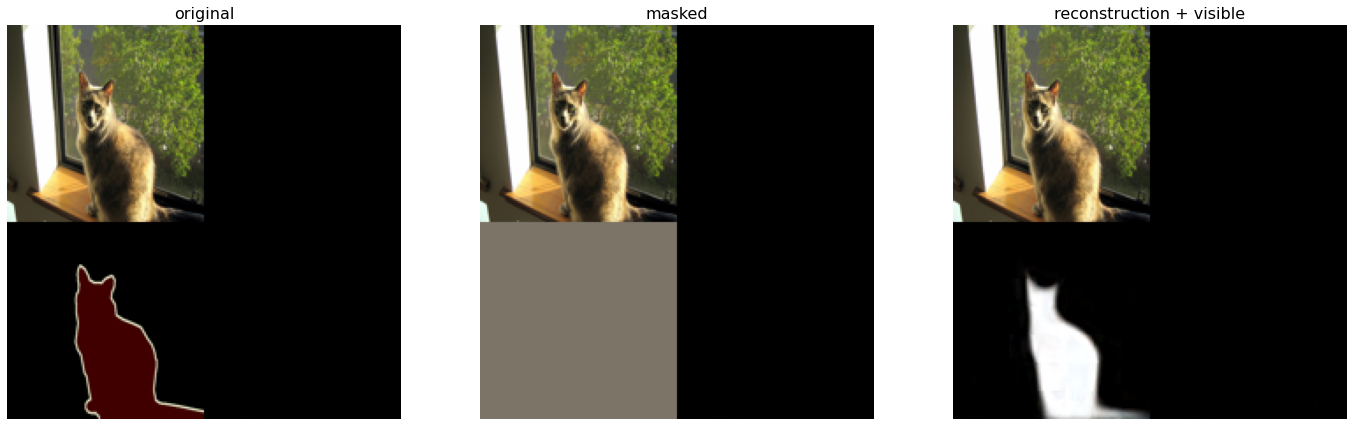

In [63]:
torch.manual_seed(2)

#model.cuda()

print('MAE with pixel reconstruction:')
reconstructed_frame = run_one_image(test_img, model)

In [132]:
data_batch            = next(data_test) #next(iter(data_train)) #
from skimage.transform import resize
from universal_mae_helpers import *

test_img   = stitch_visual_collage(data_batch, visual_cue, 16, "hwc").detach()[4, :, :, :] #torch.cat([raw_img, visual_cue[0, :, :, :]], dim=1).detach() #
test_img   = test_img - imagenet_mean
test_img   = test_img / imagenet_std

torch.manual_seed(2)

#model.cuda()

print('MAE with pixel reconstruction:')
reconstructed_frame = run_one_image(test_img, model)

concat_train_batch:torch.Size([9, 3, 224, 112])


RuntimeError: Sizes of tensors must match except in dimension 2. Got 9 and 16 in dimension 0 (The offending index is 1)

In [12]:
# clean up all functions
# AdamW optimizers

# Visualization function
# metrics and post-processing
# Prompt retrieval function
# push new repo

# multi-task

In [13]:
def prompt_reconstruction(self, x, mask_ratio):

    """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
    """

    N, L, D     = x.shape  # batch, length, dim
    len_keep    = int(L * (1 - mask_ratio))
    
    noise       = torch.arange(1, L+1).type(torch.int64).view(1, -1).to(config.device) #torch.rand(N, L, device=x.device)  # noise in [0, 1]

    all_ids     = set(list(np.arange(0, L))) 
    ids_remove  = set(list(np.arange(0, L).reshape(config.NUM_PATCHES, config.NUM_PATCHES)[int(config.NUM_PATCHES/2):, :int(config.NUM_PATCHES/2)].reshape(-1,)))
    ids_to_keep = all_ids - ids_remove

    ids_shuffle = torch.Tensor(np.array(list(ids_to_keep) + list(ids_remove))).type(torch.int64).view(1, -1).to(config.device)
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    ids_restore = ids_restore.repeat(N, 1)

    len_keep    = len(list(ids_to_keep))
    ids_keep    = torch.Tensor(np.array(list(ids_to_keep))).type(torch.int64).view(1, -1).to(config.device)

    ids_keep    = ids_keep.repeat(N, 1)

    x_masked    = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))


    # generate the binary mask: 0 is keep, 1 is remove
    mask               = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0

    # unshuffle to get the binary mask
    mask               = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore


def promptify(model):
    
    model.random_masking = types.MethodType(prompted_masking, model)
    
    return model


In [14]:
from util.datasets import * 

In [15]:
data_loader = build_multitask_dataset(["maze", "maze"], task=["path_finding_5x5", "path_finding_10x10"], split="val", batch_size=1)

NameError: name 'build_multitask_dataset' is not defined

In [ ]:
valid_loader = data_loader if False else zip(data_loader[0], data_loader[1])

In [ ]:
dummy = 0

for _data in valid_loader:
    
    dummy += 1
    
    print(dummy)

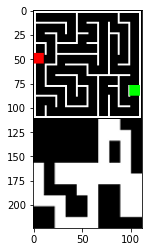

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(torch.einsum("chw->hwc", _data[0][0][0, :, :, :]))

In [ ]:
_data[1]

tensor([1])